In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, SplineTransformer
from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE, SMOTE, ADASYN
from xgboost import XGBClassifier, XGBRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
from scipy.stats import boxcox
import statsmodels.api as sm
from sklearn.svm import SVC
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

In [4]:
import matplotlib.font_manager as fm
import matplotlib

font_location = 'C:/Windows/Fonts/malgun.ttf' # 폰트 파일 이름, 디렉토리 주의
font_name = fm.FontProperties(fname = font_location).get_name()
matplotlib.rc('font', family=font_name)
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정(필수)

# 현재 글꼴 확인
print(plt.rcParams['font.family'])

['Malgun Gothic']


In [5]:
지역_df = pd.read_csv('241014_마스터_지역별식중독_A04.csv', encoding = 'cp949')

In [6]:
지역_df

,OCCRNC_YEAR,OCCRNC_MM,OCCRNC_AREA,PATNT_CNT,PATNT_CNT_3Q,환자수발생비율,OCCRNC_CNT,CPI_Value,IS_GOLDEN_HOLIDAY,GOLDEN_HOLIDAY_DAYS,...,COVID_PERIOD,COVID_Confirmed,COVID_Deaths,COVID_Fatality_Rate,COVID_Cumulative_Fatality_Rate,COVID_National_Fatality_Rate,초등학생인구비율,중학생인구비율,고등학생인구비율,60세이상인구비율
0,2015,1,강원,20,0.0,0.000013,2,94.387,1,4,...,0,0,0,0.0,0.0,0.0,0.052039,0.032632,0.037679,0.224028
1,2015,2,강원,3,1.0,0.000002,1,94.114,1,5,...,0,0,0,0.0,0.0,0.0,0.051954,0.032347,0.037633,0.225252
2,2015,3,강원,26,0.0,0.000017,2,94.246,0,0,...,0,0,0,0.0,0.0,0.0,0.051771,0.032019,0.037737,0.226772
3,2015,4,강원,10,0.0,0.000006,2,94.227,0,0,...,0,0,0,0.0,0.0,0.0,0.051616,0.031807,0.037645,0.227450
4,2015,5,강원,11,0.0,0.000007,2,94.510,1,7,...,0,0,0,0.0,0.0,0.0,0.051485,0.031494,0.037567,0.228041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1627,2022,8,충북,6,1.0,0.000004,2,109.610,1,3,...,0,0,0,0.0,0.0,0.0,0.053167,0.027235,0.026448,0.284102
1628,2022,9,충북,10,0.0,0.000006,2,109.990,1,4,...,0,0,0,0.0,0.0,0.0,0.053024,0.027233,0.026605,0.284921
1629,2022,10,충북,2,1.0,0.000001,1,110.160,1,6,...,0,0,0,0.0,0.0,0.0,0.052823,0.027126,0.026768,0.286165
1630,2022,11,충북,16,0.0,0.000010,2,109.880,0,0,...,0,0,0,0.0,0.0,0.0,0.052603,0.027162,0.026869,0.287179


- OCCRNC_CNT > 0인 데이터만 추출

In [8]:
지역_df_over_0 = 지역_df.loc[지역_df.OCCRNC_CNT > 0].copy()

- OCCRNC_CNT BOXCOX 변환
  - 모델 성능에 영향 없음

In [12]:
OCCRNC_CNT_BOXCOX, OCCRNC_CNT_lambda = boxcox(지역_df_over_0['OCCRNC_CNT'])

In [13]:
지역_df_over_0['OCCRNC_CNT_BOXCOX'] = OCCRNC_CNT_BOXCOX

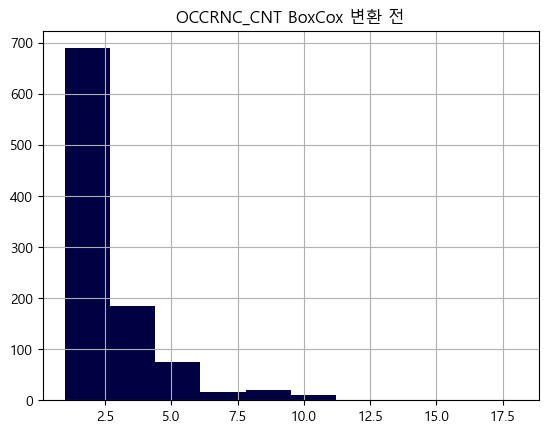

In [206]:
지역_df_over_0.OCCRNC_CNT.hist(color = '#000043')
plt.title('OCCRNC_CNT BoxCox 변환 전')
plt.show()

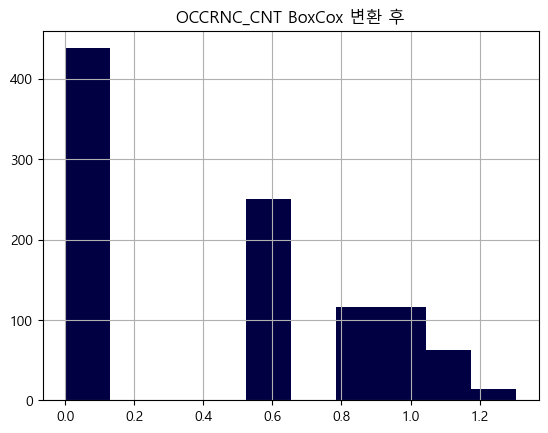

In [208]:
지역_df_over_0.OCCRNC_CNT_BOXCOX.hist(color = '#000043')
plt.title('OCCRNC_CNT BoxCox 변환 후')
plt.show()

- 독립 / 종속변수 이상치 대체

변수 상/하한의 IQR * 3배로 이상치 대체

In [390]:
def convert_outlier(x):
    q1, q3 = x.quantile([0.25, 0.75])
    IQR = q3 - q1
    upper_bound = q3 + IQR *1.5
    lower_bound = q1 - IQR *1.5
    x = x.clip(lower_bound, upper_bound)
    return x

In [267]:
지역_df_over_0.columns

Index(['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA', 'PATNT_CNT', 'PATNT_CNT_3Q',
       '환자수발생비율', 'OCCRNC_CNT', 'CPI_Value', 'IS_GOLDEN_HOLIDAY',
       'GOLDEN_HOLIDAY_DAYS', 'Festival_Count', 'Festival Exists', 'avg_temp',
       'avg_high_temp', 'avg_low_temp', 'avg_precip', 'avg_windspeed',
       'max_windspeed', 'avg_pressure', 'max_pressure', 'min_pressure',
       'avg_sea_pressure', 'max_sea_pressure', 'min_sea_pressure',
       'avg_relative_humidity', 'min_relative_humidity', 'sum_sunshine_hour',
       'binary', '학교당학생수평균', '집단급식소인허가수', 'COVID_PERIOD', 'COVID_Confirmed',
       'COVID_Deaths', 'COVID_Fatality_Rate', 'COVID_Cumulative_Fatality_Rate',
       'COVID_National_Fatality_Rate', '초등학생인구비율', '중학생인구비율', '고등학생인구비율',
       '60세이상인구비율', 'OCCRNC_CNT_BOXCOX'],
      dtype='object')

In [394]:
for col in ['OCCRNC_CNT','Festival_Count','avg_precip','avg_windspeed','max_windspeed','min_pressure','min_sea_pressure'
            ,'min_relative_humidity','sum_sunshine_hour','집단급식소인허가수','COVID_Confirmed','COVID_Deaths','COVID_Fatality_Rate'
            ,'초등학생인구비율','중학생인구비율']:
    지역_df_over_0[col] = convert_outlier(지역_df_over_0[col])

In [73]:
X = 지역_df_over_0.drop(columns = ['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_AREA', 'PATNT_CNT', 'PATNT_CNT_3Q','환자수발생비율','OCCRNC_CNT','binary','OCCRNC_CNT_BOXCOX'])

In [97]:
y = 지역_df_over_0.OCCRNC_CNT

In [99]:
y_boxcox = 지역_df_over_0.OCCRNC_CNT_BOXCOX

- 스케일링 및 다항변환

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [149]:
X_train, X_test, y_boxcox_train, y_boxcox_test = train_test_split(X, y_boxcox, random_state=42)

In [103]:
mm_scaler = MinMaxScaler()
X_train_sc = mm_scaler.fit_transform(X_train)
X_test_sc = mm_scaler.transform(X_test)

In [105]:
poly = PolynomialFeatures(degree = 2)
X_train_poly = poly.fit_transform(X_train_sc)
X_test_poly = poly.transform(X_test_sc)

- 스플라인회귀

In [113]:
spline = SplineTransformer()
X_train_spline = spline.fit_transform(X_train_sc)
X_test_spline = spline.transform(X_test_sc)

spline_lr_model = LinearRegression()
spline_lr_model.fit(X_train_spline, y_train)

LinearRegression()

In [115]:
spline_lr_model.score(X_test_spline, y_test)

-6.174912926701109e+18

In [117]:
result = []

for n_knots in range(2, 6):
    for degree in range(1, 6):
        
        spline = SplineTransformer(n_knots, degree)
        X_train_spline = spline.fit_transform(X_train_sc)
        X_test_spline = spline.transform(X_test_sc)
        
        spline_lr_model = LinearRegression()
        spline_lr_model.fit(X_train_spline, y_train)
        result.append([n_knots,degree,spline_lr_model.score(X_test_spline, y_test)])

In [204]:
pd.DataFrame(result, columns = ['n_knots','degree','r2']).sort_values(by = 'r2', ascending = False)[:10]

,n_knots,degree,r2
2,2,3,0.302369
7,3,3,0.296800
1,2,2,0.290248
5,3,1,0.284064
3,2,4,0.281950
6,3,2,0.273372
0,2,1,0.267352
4,2,5,-6.771979
8,3,4,-12.418179
9,3,5,-6355.840001


- XGBoost 회귀

In [178]:
def rf_reg_modeling(X, y, model, param):

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    rf_grid = GridSearchCV(estimator=model, param_grid=param, scoring = 'r2')
    rf_grid.fit(X_train, y_train)
    print(f'R2 = {rf_grid.score(X_test, y_test)}, best_param = {rf_grid.best_params_}')
    return rf_grid

- 기본모형

In [186]:
xgb_reg_model.fit(X_train, y_boxcox_train)

xgb_reg_model.score(X_test, y_boxcox_test)

0.10211784961641457

In [127]:
xgb_reg_model = XGBRegressor(random_state = 42)

- 개선모형

In [188]:
rf_reg_modeling(X, y, model = XGBRegressor(random_state = 42), param = {'n_estimators':[100,200,300]})

R2 = 0.3516604432600533, best_param = {'n_estimators': 100}


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             param_grid={'n_estimators': [100, 200, 300]}, scoring='r2')

- Random Forest 회귀

In [133]:
rf_reg_model = RandomForestRegressor(random_state = 42)

- 기본모형

In [176]:
rf_reg_model.fit(X_train, y_boxcox_train)

rf_reg_model.score(X_test, y_boxcox_test)

0.2507621712140692

- 개선모형

In [192]:
rf_reg_model.fit(X_train, y_train)

rf_reg_model.score(X_test, y_test)

0.40737165775401085

In [194]:
rf_reg_modeling(X, y, rf_reg_model, {'n_estimators':[100]})

R2 = 0.40737165775401085, best_param = {'n_estimators': 100}


GridSearchCV(estimator=RandomForestRegressor(random_state=42),
             param_grid={'n_estimators': [100]}, scoring='r2')